### Imports

In [30]:
import sklearn
from sklearn import *
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import tensorly as tl
from tensorly import *
import scipy
import time

### Load the dataset

In [2]:
path = "./data_3_variables/"
n_person = 10
n_view = 9
n_illum = 6
x_size = 200
y_size = 200

images = np.empty((n_person, n_view, n_illum, x_size* y_size))
for im_name in os.listdir(path):
    parsed = im_name.split("_")
    person = int(parsed[0])
    view   = int(-int(parsed[1])/4)
    illum  = int(int(parsed[4])/15)-1
    images[person, view, illum] = cv2.resize(cv2.imread( path+im_name, 0), (x_size, y_size)).reshape(-1)/ 255.

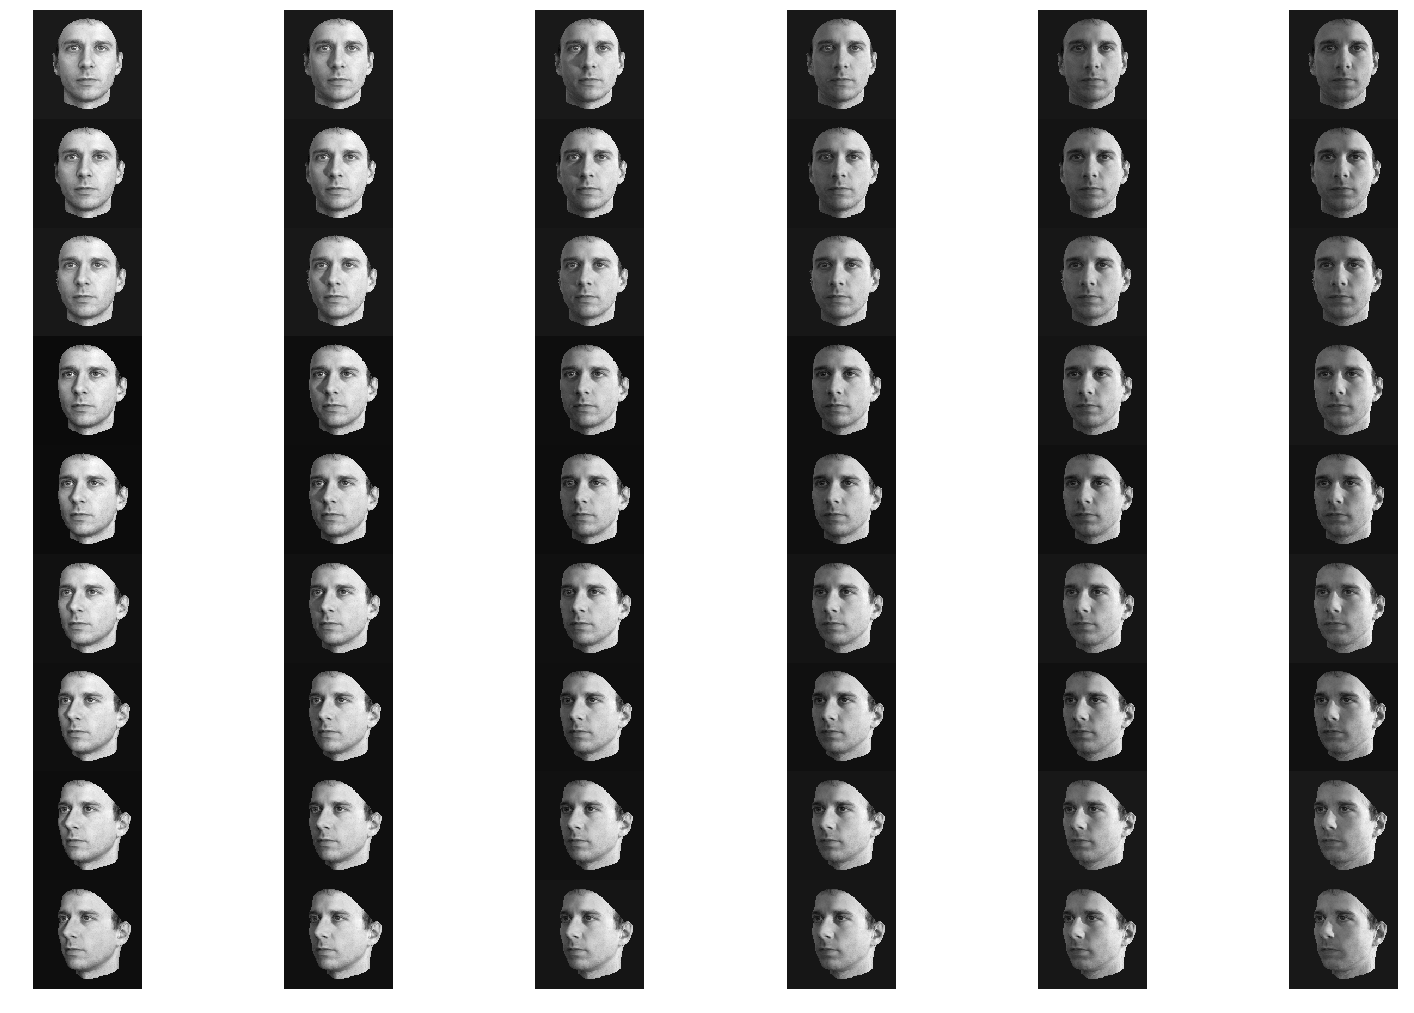

In [3]:
def plot_tensor_slice(T, x_size=x_size, y_size=y_size,  n=0):
    fig = plt.figure(figsize=(3*T.shape[1], 3*T.shape[2]))
    fig.subplots_adjust(wspace=0, hspace=0)
    for i in range(T.shape[1]):
        for j in range(T.shape[2]):
            sub = fig.add_subplot(T.shape[1],T.shape[2],T.shape[2]*i + j+1)
            plt.imshow(T[n,i,j].reshape(x_size, y_size), cmap="gray")
            plt.axis("off")
    plt.show()
plot_tensor_slice(images, n=0)

The dataset we used, was built using 3D scans of 10 differents persons, from which they extracted 200*200 pixels images from 9 different angle of view and 6 different illumination. The image above is the first slice along the person mode of the data tensor, ie all the pictures of the first person. <br><br>
From this data set we will create the training set by removing :
    - the slices along the view point mode of index so that : view_index % 3 == 1
    - the slices along the illumination mode of index so that : illum_index % 2 == 1
It result a training tensor of shape [10, 6, 3, 40000] <br><br>
The test set is the list of images from the data tensor where the index is such that :
    - view_index % 3 == 1  AND illum_index % 3 = 1
It result a list of 90 images.

In [34]:
X_test = []
y_test = []
view_index = [i for i in range(n_view) if i%3 != 1]
illum_index = [i for i in range(n_illum) if i%2 != 1]
n_view2 = len(view_index)
n_illum2 = len(illum_index)
X_train = np.empty((n_person, n_view2, n_illum2, x_size*y_size ))
for i in range(n_person):
    for j in range(n_view):
        for k in range(n_illum):
            if j%3 == 1 and k%2 == 1:
                X_test.append(images[i,j,k])
                y_test.append(i)
            elif j%3 != 1 and k%2 != 1:
                X_train[i, view_index.index(j), illum_index.index(k)] = images[i,j,k]
            else:
                pass
X_test = np.array(X_test).reshape(-1, x_size*y_size)
y_test = np.array(y_test)

The image below is the first slice along the person mode of the training tensor.

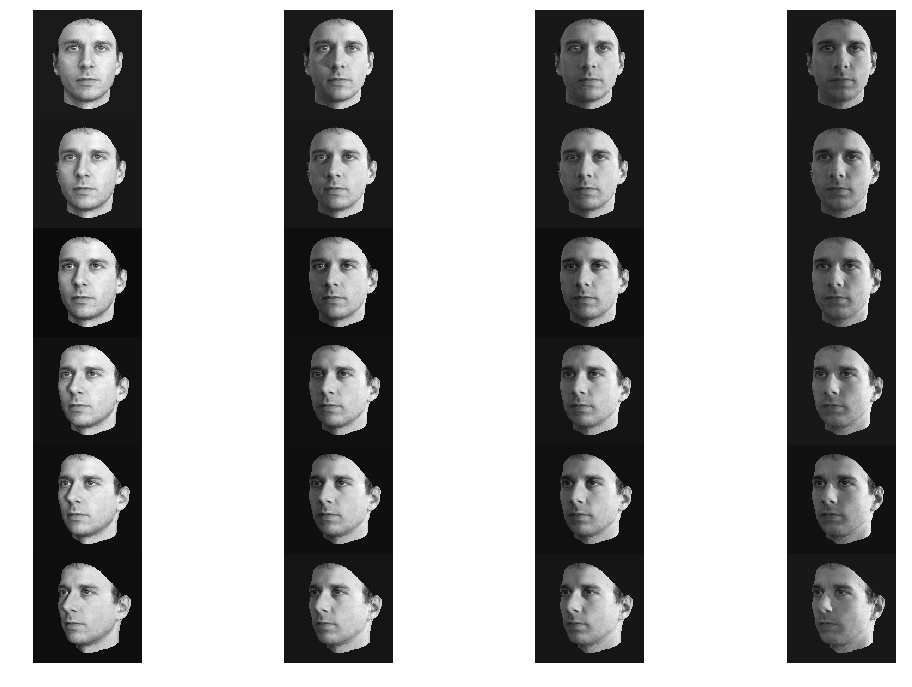

In [6]:
plot_tensor_slice(X_train, n=0)

----------------
#### MPCA

In [11]:
def cov(M, kernel="linear", degree=2, alpha=1, beta=0, sigma=1 ):
    assert isinstance(M, np.ndarray)
    assert M.ndim == 2
    cov = np.empty((M.shape[0], M.shape[0]))
    for i in range(M.shape[0]):
        for j in range(M.shape[0]):
            if kernel == "linear":
                    cov[i,j] = M[i,:].dot(M.T[:,j])
            elif kernel == "poly":
                cov[i,j] = M[i,:].dot(M.T[:,j])**degree
            elif kernel == "sigmoid":
                cov[i,j] = np.tanh( alpha * M[i,:].dot(M.T[:,j]) + beta )
            elif kernel == "rbf" :
                cov[i,j] = np.exp(- np.linalg.norm(M[i,:] - M.T[:,j])**2)
            else : 
                raise IllegalArgumentError("kernel must be 'linear', 'poly', 'sigmoid', 'rbf'")
    return cov

In [12]:
def HOSVD(T, N=None, ranks=None, kernel="linear", iter_max=10, e=10, degree=2, alpha=1, beta=0, sigma=1 ):
    """ Perform HOSVD on the tensor T on the first n modes of the tensor
        and performs the truncated HOSVD, if ranks is given.
        
        Parameters :
            T :
                    the tensor
            n :
                    set to None by default which perform the HOSVD and all the modes
                    if given must be an int >0, the HOSVD is then performed on the n first modes of T
            ranks : 
                    None by default, if given, must be an array of int of size n, and all of its values must be >0
        Returns (Z, U, U_T, S, V) where :
            Z is the core tensor
            U is the list of U matrices from the SVD
            U is the list of U^T matrices from the SVD
            S is the list of S matrices from the SVD
            V is the list of V matrices from the SVD
    """
    assert isinstance(T, np.ndarray)
    if N is None:
        N = T.ndim
    trunc = True #tells if we perform HOSVD with truncation 
    if ranks is None:
        ranks = np.array(T.shape)[:N]
        trunc = False
    assert N == len(ranks)
    U = list(np.empty(N))
    U_T = list(np.empty(N))
    V = list(np.empty(N))
    S = list(np.empty(N))
    for i in range(N):
        Tm = tl.base.unfold(T, i)
        u, s, v = np.linalg.svd( cov(Tm, kernel=kernel, degree= degree, alpha=alpha, beta=beta, sigma=sigma ) , full_matrices=False)
        U[i] = u[:, :ranks[i]]
        U_T[i] = u[:, :ranks[i]].T
        S[i] = s[:ranks[i]]
        V[i] = v[:ranks[i]]
    
    if not trunc:
        #if no truncation, then returns the values
        return tl.tenalg.multi_mode_dot(T, U_T, np.arange(N)), U, U_T, S, V
    
    prev = float("inf")
    #otherwise, local optimization using altenating least squares
    for j in range(iter_max):
        for n in range(N):
            # compute X = T x_1 U_1^T ... x_{n-1} U_{n-1}^T x_{n+1} U_{n+1}^T ... x_N U_N^T
            first = True # a flag that tell if we have already computed T x_1 U_1^T
            for i in range(N):
                if i == n: continue
                if first:
                    first = False
                    X = tl.tenalg.mode_dot(T, U_T[i], i)
                else:
                    X = tl.tenalg.mode_dot(X, U_T[i], i)
            U_n, _, _ = np.linalg.svd(tl.base.unfold(X,n), full_matrices=False)
            U_n = U_n[:,:ranks[n]]
            U[n] = U_n
            U_T[n] = U_n.T
        Z = tl.tenalg.mode_dot(X, U_T[N-1], N-1)
        T_2 = tl.tenalg.multi_mode_dot(Z, U, np.arange(N))
        current = np.linalg.norm(T - T_2)**2
        if abs( current - prev) <= e :
            break
        prev = current
    return  Z, U, U_T, S, V

In [13]:
def MICA(T, N=None, ranks=None, kernel="linear", fun="logcosh",  iter_max=10, e=10, degree=2, alpha=1, beta=0, sigma=1):
    """ Perform MICA on the tensor T on the first n modes of the tensor
        and performs the truncated HOSVD, if ranks is given.
        
        Parameters :
            T :
                    the tensor
            n :
                    set to None by default which perform the HOSVD and all the modes
                    if given must be an int >0, the HOSVD is then performed on the n first modes of T
            ranks : 
                    None by default, if given, must be an array of int of size n, and all of its values must be >0
        Returns (Z, U, U_T, S, V) where :
            Z is the core tensor
            U is the list of U matrices from the SVD
            U is the list of U^T matrices from the SVD
            S is the list of S matrices from the SVD
            V is the list of V matrices from the SVD
    """
    assert isinstance(T, np.ndarray)
    if N is None:
        N = T.ndim
    trunc = True #tells if we perform HOSVD with truncation 
    if ranks is None:
        ranks = np.array(T.shape)[:N]
        trunc = False
    assert N == len(ranks)
    
#     C = list(np.empty(N))
    C_inv = list(np.empty(N))
    for i in range(N):
        Tm = tl.base.unfold(T, i)
        covT = cov(Tm, kernel=kernel)
        u, s, v = np.linalg.svd( covT , full_matrices=False)
        w = sklearn.decomposition.fastica_.fastica(cov(tl.base.unfold(T, i), kernel=kernel, degree= degree, alpha=alpha, beta=beta, sigma=sigma), fun=fun)[1]
        c = u.dot(np.linalg.inv(w)) [:, :ranks[i]]
        C_inv[i] = np.linalg.pinv(c)
    
#     if not trunc:
        #if no truncation, then returns the values
    return tl.tenalg.multi_mode_dot(T, C_inv, np.arange(N)), C_inv
    
#     prev = float("inf")
#     #otherwise, local optimization using altenating least squares
#     for j in range(iter_max):
#         for n in range(N):
#             # compute X = T x_1 U_1^T ... x_{n-1} U_{n-1}^T x_{n+1} U_{n+1}^T ... x_N U_N^T
#             first = True # a flag that tell if we have already computed T x_1 U_1^T
#             for i in range(N):
#                 if i == n: continue
#                 if first:
#                     first = False
#                     X = tl.tenalg.mode_dot(T, C_inv[i], i)
#                 else:
#                     X = tl.tenalg.mode_dot(X, C_inv[i], i)
#             U_n, _, _ = np.linalg.svd(tl.base.unfold(X,n), full_matrices=False)
#             U_n = U_n[:,:ranks[n]]
#             U[n] = U_n
#             U_T[n] = U_n.T
#         Z = tl.tenalg.mode_dot(X, U_T[N-1], N-1)
#         T_2 = tl.tenalg.multi_mode_dot(Z, U, np.arange(N))
#         current = np.linalg.norm(T - T_2)**2
#         if abs( current - prev) <= e :
#             break
#         prev = current
#     return  tl.tenalg.multi_mode_dot(T, C_inv, np.arange(N)), C_inv

In [14]:
def pinv_tensor(T, mode):
    assert isinstance(T, np.ndarray)
    assert T.ndim > mode
    
    Tm = tl.base.unfold(T, mode)
    pinv = np.linalg.pinv(Tm).T
    return tl.base.fold(pinv, mode, T.shape)

In [15]:
def projection_algo(T, v, mode=3):
    
    pinv = pinv_tensor(T, mode)
    respT = tl.tenalg.mode_dot(pinv, v.T, mode)
    return HOSVD(respT, N=3, ranks=[1,1,1])[1]

--------------
### Experiments
For each experiment, we apply MPCA, or MICA with different hyperparameters, on the training tensor. Which return a core tensor. To perform the facial recognition we project 

In [40]:
Z, U, U_T, S, V = HOSVD(X_train, N=3)

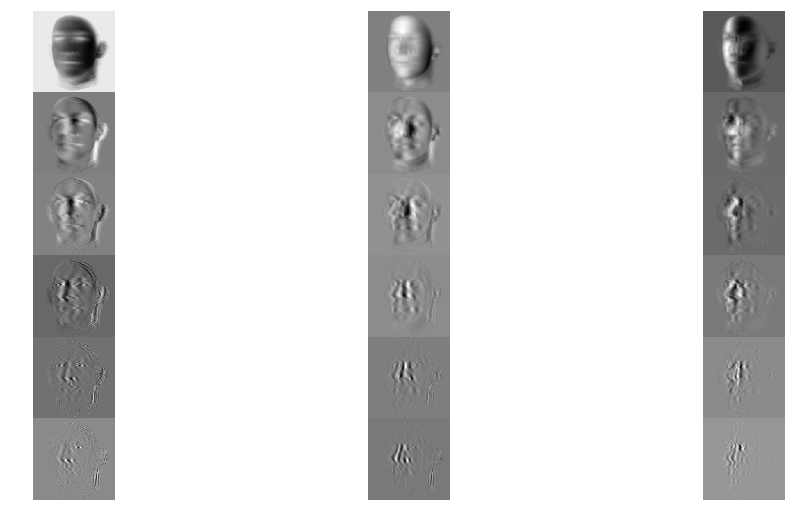

In [38]:
plot_tensor_slice(Z, n=0)

In [41]:
start = time.time()
x_train = []
y_train = []
for i in range(n_person):
    for j in range(n_view2):
        for k in range(n_illum2):
            x_train.append(projection_algo(Z, X_train[i,j,k])[0])
            y_train.append(i)
x_train = np.array(x_train).reshape(-1, n_person)
y_train = np.array(y_train)
x_test = []
for i in range(len(X_test)):
    x_test.append(projection_algo(Z, X_test[i])[0])
x_test = np.array(x_test).reshape(-1,10)
print(f"elapsed time {time.time() - start}")

elapsed time 332.2600586414337


In [42]:
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [43]:
knn.score(x_test, y_test)

0.4888888888888889

In [54]:
np.save("./projections/MPCA_core_tensor",Z )
np.save("./projections/MPCA_x_train",x_train )
np.save("./projections/MPCA_x_test",x_test )

---------
### MPCA with kernel poly of degree 2

In [27]:
Z, U, U_T, S, V = HOSVD(X_train, N=3, kernel="poly", degree=2)

In [28]:
start = time.time()
x_train = []
y_train = []
for i in range(n_person):
    for j in range(n_view2):
        for k in range(n_illum2):
            x_train.append(projection_algo(Z, X_train[i,j,k])[0])
            y_train.append(i)
x_train = np.array(x_train).reshape(-1, n_person)
y_train = np.array(y_train)
x_test = []
for i in range(len(X_test)):
    x_test.append(projection_algo(Z, X_test[i])[0])
x_test = np.array(x_test).reshape(-1,10)
print(f"elapsed time {time.time() - start}")

In [29]:
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(x_train, y_train)
knn.score(x_test, y_test)

0.2833333333333333

In [62]:
exp = "kMPCA_poly2"
np.save(f"./projections/{exp}_core_tensor",Z )
np.save(f"./projections/{exp}_x_train",x_train )
np.save(f"./projections/{exp}_x_test",x_test )

---------
### MPCA with kernel sigmoid

In [31]:
Z, U, U_T, S, V = HOSVD(X_train, N=3, kernel="sigmoid")

In [32]:
start = time.time()
x_train = []
y_train = []
for i in range(n_person):
    for j in range(n_view2):
        for k in range(n_illum2):
            x_train.append(projection_algo(Z, X_train[i,j,k])[0])
            y_train.append(i)
x_train = np.array(x_train).reshape(-1, n_person)
y_train = np.array(y_train)
x_test = []
for i in range(len(X_test)):
    x_test.append(projection_algo(Z, X_test[i])[0])
x_test = np.array(x_test).reshape(-1,10)
print(f"elapsed time {time.time() - start}")

elapsed time 438.51744627952576


In [33]:
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(x_train, y_train)
knn.score(x_test, y_test)

0.3

In [67]:
exp = "kMPCA_sigmoid"
np.save(f"./projections/{exp}_core_tensor",Z )
np.save(f"./projections/{exp}_x_train",x_train )
np.save(f"./projections/{exp}_x_test",x_test )

---------
### MICA logcosh

In [68]:
Z, C_inv = MICA(X_train, N=3, fun="logcosh")

In [69]:
x_train = []
y_train = []
for i in range(n_person):
    for j in range(n_view2):
        for k in range(n_illum2):
            x_train.append(projection_algo(Z, X_train[i,j,k])[0])
            y_train.append(i)
x_train = np.array(x_train).reshape(-1, n_person)
y_train = np.array(y_train)
x_test = []
for i in range(len(X_test)):
    x_test.append(projection_algo(Z, X_test[i])[0])
x_test = np.array(x_test).reshape(-1,10)

In [70]:
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(x_train, y_train)
knn.score(x_test, y_test)

0.6222222222222222

In [71]:
exp = "MICA_logcosh"
np.save(f"./projections/{exp}_core_tensor",Z )
np.save(f"./projections/{exp}_x_train",x_train )
np.save(f"./projections/{exp}_x_test",x_test )

---------
### MICA with exp function for negentropy

In [72]:
Z, C_inv = MICA(X_train, N=3, fun="exp")

In [73]:
x_train = []
y_train = []
for i in range(n_person):
    for j in range(n_view2):
        for k in range(n_illum2):
            x_train.append(projection_algo(Z, X_train[i,j,k])[0])
            y_train.append(i)
x_train = np.array(x_train).reshape(-1, n_person)
y_train = np.array(y_train)
x_test = []
for i in range(len(X_test)):
    x_test.append(projection_algo(Z, X_test[i])[0])
x_test = np.array(x_test).reshape(-1,10)

In [74]:
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(x_train, y_train)
knn.score(x_test, y_test)

0.6222222222222222

In [75]:
exp = "MICA_exp"
np.save(f"./projections/{exp}_core_tensor",Z )
np.save(f"./projections/{exp}_x_train",x_train )
np.save(f"./projections/{exp}_x_test",x_test )


---------
### MICA logcosh poly 2

In [79]:
Z, C_inv = MICA(X_train, N=3, fun="logcosh", kernel="poly", degree=2)

/home/adrien/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


In [80]:
x_train = []
y_train = []
for i in range(n_person):
    for j in range(n_view2):
        for k in range(n_illum2):
            x_train.append(projection_algo(Z, X_train[i,j,k])[0])
            y_train.append(i)
x_train = np.array(x_train).reshape(-1, n_person)
y_train = np.array(y_train)
x_test = []
for i in range(len(X_test)):
    x_test.append(projection_algo(Z, X_test[i])[0])
x_test = np.array(x_test).reshape(-1,10)

In [81]:
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(x_train, y_train)
knn.score(x_test, y_test)

0.6222222222222222

In [82]:
exp = "kMICA_logcosh_poly2"
np.save(f"./projections/{exp}_core_tensor",Z )
np.save(f"./projections/{exp}_x_train",x_train )
np.save(f"./projections/{exp}_x_test",x_test )

---------
### MICA logcosh sigmoid

In [87]:
Z, C_inv = MICA(X_train, N=3, fun="logcosh", kernel="sigmoid")

/home/adrien/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:316: RuntimeWarning: divide by zero encountered in true_divide
  K = (u / d).T[:n_components]  # see (6.33) p.140
/home/adrien/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:316: RuntimeWarning: invalid value encountered in true_divide
  K = (u / d).T[:n_components]  # see (6.33) p.140


ValueError: array must not contain infs or NaNs